**Import Library**

In [37]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

In [38]:
# Image directories
train_dir = "images/training/"
test_dir = "images/test/"

***Langkah 1 - Load Data dan Visualisasikan***

In [39]:
def load_dataset(img_dir):
    p = Path(img_dir) #dibaca dengan kode ini
    dirs = p.glob('*')

    img_list = [] #digunakan listing semua file dalam glob akan dapat directori day dan night

    for dir in dirs:
        print(f'sekarang di direktori {dir}')
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.jpg'): #membaca gambar
            
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [40]:
# Load training data
train_img = load_dataset(train_dir)

sekarang di direktori images\training\day
sekarang di direktori images\training\night


Lakukan pengecekan pada salah satu data pada list. List harus berisi tuple dengan dua data, yaitu data gambar dan label dari gambar.

In [41]:
# Check the first data
# It should be a tuple consist of arrays of image and image labels
train_img[0]

(array([[[158, 194, 218],
         [158, 194, 218],
         [158, 194, 218],
         ...,
         [176, 209, 228],
         [177, 210, 229],
         [177, 210, 229]],
 
        [[158, 194, 218],
         [158, 194, 218],
         [158, 194, 218],
         ...,
         [180, 213, 232],
         [180, 213, 232],
         [180, 213, 232]],
 
        [[158, 194, 218],
         [158, 194, 218],
         [158, 194, 218],
         ...,
         [177, 210, 229],
         [177, 210, 229],
         [177, 210, 229]],
 
        ...,
 
        [[ 35,  40,  43],
         [ 38,  43,  46],
         [ 39,  44,  47],
         ...,
         [ 65,  73,  75],
         [ 65,  73,  75],
         [ 65,  73,  75]],
 
        [[ 36,  41,  44],
         [ 38,  43,  46],
         [ 39,  44,  47],
         ...,
         [ 68,  76,  78],
         [ 68,  76,  78],
         [ 65,  73,  75]],
 
        [[ 37,  41,  44],
         [ 38,  43,  46],
         [ 39,  44,  47],
         ...,
         [ 68,  76,  78],
  

Cek ukuran gambar secara acak

In [42]:
# Random size checking
pick_random = np.random.randint(0, len(train_img))

# Check img size
print(f'Image {pick_random}')
print(train_img[pick_random][0].shape)

Image 140
(614, 857, 3)


Tampilkan gambar untuk inspeksi secara visual. Buatlah fungsi untuk membantu memvisualkan gambar

In [43]:
# Function to Visualize
def random_img_viz(img_list):
    rand_num = np.random.randint(0, len(img_list))

    img = img_list[rand_num][0]
    label = img_list[rand_num][1]
    label_str = 'day' if label == 1 else 'night'

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

Lakukan visualisasi gambar secara acak

Shape	: (458, 800, 3)
Label	: images\training\day


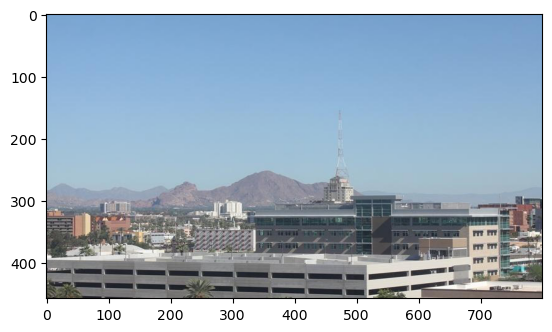

In [44]:
random_img_viz(train_img)

***Langkah 3 - Pra Pengolahan Data***
Pada tahap ini, kita akan melakukan dua proses utama, yaitu standardisasi ukuran gambar, dan encoding label gambar.

Bualah fungsi berikut untuk menstandarkan ukuran gambar

In [29]:
def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))
    #open cv widht x height kolom baris
    #konteks shpe height x widht baris kolom

    return std_img

Selanjutnya, buatlah fungsi untuk kebutuhan encoding label

In [45]:
def label_encoder(label):
    # Encode the label
    # day as 1; night as 0
    num_val = 0

    if(label == 'day'):
        num_val = 1
    
    return num_val

Terakhir, buatlah fungsi untuk melakukan kedua hal tersebut secara sekaligus untuk semua gambar dalam list.

In [46]:
def preprocess(img_list):
    std_img_list = []

    for item in img_list:
        image = item[0]
        label = item[1]

        # Standarized the image
        std_img = standarized_input(image)

        # Create the label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))
    
    return std_img_list

In [49]:
# Lakukan pra pengolahan data pada data training.
train_std_img_list = preprocess(train_img)

In [50]:
# Lakukan pengecekan ukuran gambar secara acak
# Random size checking
pick_random = np.random.randint(0, len(train_std_img_list))

# Check img size
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 188
(600, 1100, 3)


WARNING! Perhatikan ukuran (shape) dari data image. Atribut shape akan menampilkan dalam konteks baris (height) x kolom (width)

Lakukan inspeksi visual dengan fungsi random_img_viz yang telah dibuat sebelumnya pada gambar hasil pra pengolahan.

Shape	: (600, 1100, 3)
Label	: 0


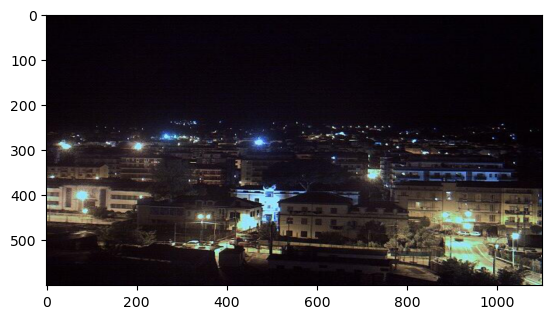

In [51]:
random_img_viz(train_std_img_list)

***Langkah 4 - Ekstraksi Fitur***

Selanjutnya, untuk dapat membadakan antara label satu dengan label yang lain, kita memerlukan sebuah fitur. Fitur adalah penciri dari sebuah data yang dapat digunakan untuk membendakan data satu dengan yang lain. Pada percobaan kali ini, kita akan menggunakan fitur yang sederhana yaitu nilai rata-rata dari tingkat kecerahan gambar (average brightness). Namun sebelum dapat melakukan hal tersebut, kita akan mengubah ruang warna (colorspace) dari RGB menjadi HSV (Hue, Saturation, Value). Hal ini dikarenakan, tingkat kecerahan (brightness) lebih mudah didapatkan dari HSV berdasarkan nilai Valuenya.

Buatlah fungsi berikut untuk mendapatkan nilai rata-rata tingkat kecerahan

In [52]:
# Get feature based on average brightness using HSV colorspace
def avg_brightness(image):
    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #hsv channel 0=h, s=1, v=2 teteap 3 dimensi
    # Calculate the avg of brightness
    sum_brightness = np.sum(img_hsv[:,:,2]) # take the 3rb value which is the V channel
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area

    return avg

Lakukan pengecekan pada gambar secara acak. INGAT! Gunakan gambar yang telah melalui proses pra pengolahan data!

Image 28
Avg Brighness: 105.6181


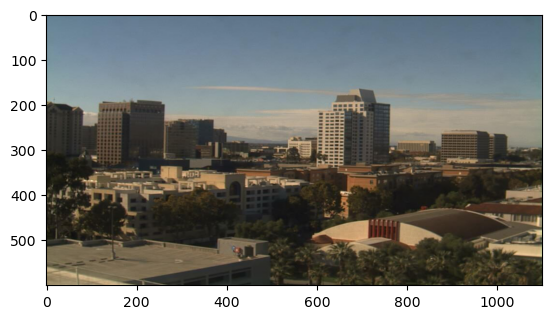

In [53]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list))

feature_img = train_std_img_list[rand_img][0]

avg_img = avg_brightness(feature_img)

print(f'Image {rand_img}')
print(f'Avg Brighness: {avg_img:.4f}')
plt.imshow(feature_img)

***Langkah 5 - Klasifikasi dengan Metode Threshold***

Pada tahap ini, kita akan melakukan proses klasifikasi sederhana dengan menggunakan nilai ambang batas (threshold) dari nilai rata-rata kecerahan yang kita tentukan sendiri.

Buatlah fungsi berikut,

In [8]:
def predict_label(img, threshold):
    # Computer average brightness
    avg = avg_brightness(img)
    pred = 0

    # Predict the label based on user defined threshold
    if avg > threshold:
        pred = 1
    
    return pred

Lakukan pengecekan prediksi secara acak pada data training

Image 129
Actual label: 0
Predicted label: 0


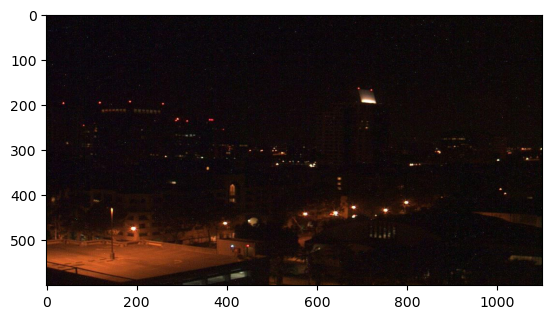

In [54]:
# Test the classifier on train data
rand_img = np.random.randint(0, len(train_std_img_list))

pred = predict_label(train_std_img_list[rand_img][0], threshold=120)

# Evaluate
print(f'Image {rand_img}')
print(f'Actual label: {train_std_img_list[rand_img][1]}')
print(f'Predicted label: {pred}')
plt.imshow(train_std_img_list[rand_img][0])

mencoba semua data dan dibagi jumlah datanya

In [ ]:
def evaluate(img_list, threshold):
    miss_labels = []

    for file in img_list:
        # Get the ground truth / correct label
        img = file[0]
        label = file[1]

        # Get prediction
        pred_label = predict_label(img, threshold)

        # Compare ground truth and pred
        if pred_label != label:
            miss_labels.append((img, pred_label, label))
    
    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img

    print(f'Accuracy: {accuracy:.4f}')
    #.4f mengeluarkan 4 angka dibelakang koma